In [19]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [20]:
from src.face import FaceDetector
from src.mask import MaskHandler
from src.utils.project_utils import Utils
from src.region import Region
from src.superpixels import SuperpixelExtractor
from src.feature import FeatureExtractor, EFeature

In [21]:
face_detector = FaceDetector('../assets/lbfmodel.yaml')
IMAGE_PATH = Path('test_images/lebron.jpg')

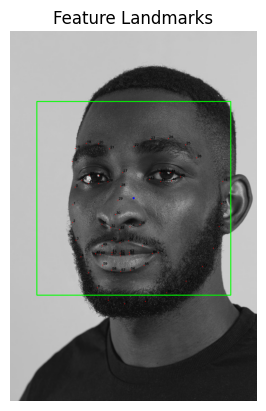

In [22]:
img_rgb, _, _, landmarks_all_faces = face_detector.detect(
    IMAGE_PATH,
    display_indices=True
)

Utils.display(img_rgb, title="Feature Landmarks")

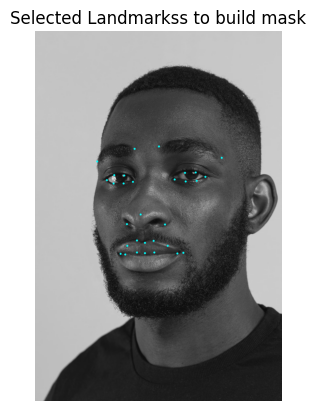

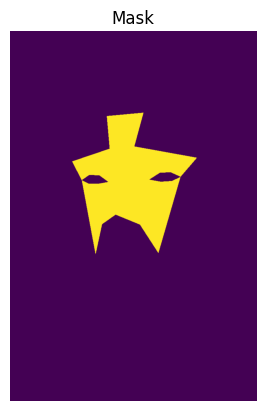

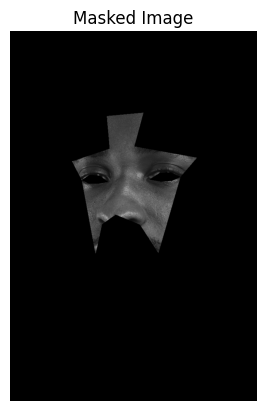

In [23]:
mask_handler = MaskHandler()

masked_img, selected_pts = mask_handler.get_mask_points(
    IMAGE_PATH,
    landmarks_all_faces
)
Utils.display(masked_img, "Selected Landmarkss to build mask")

masks, masked_imgs = mask_handler.build_masks(
    IMAGE_PATH,
    selected_pts,
    landmarks_all_faces
)
Utils.display(masks[0], "Mask")
Utils.display(masked_imgs[0], "Masked Image")

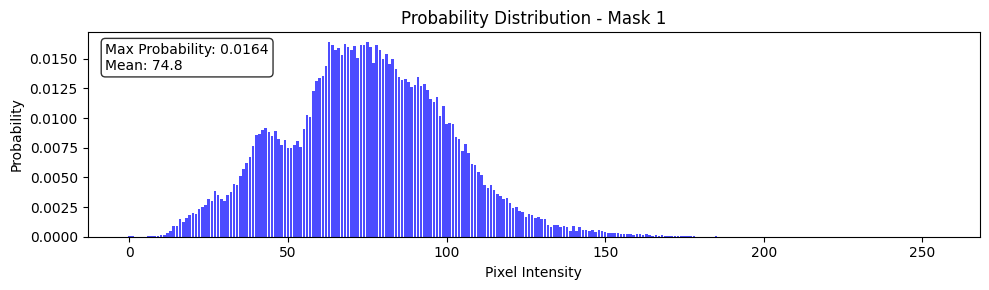

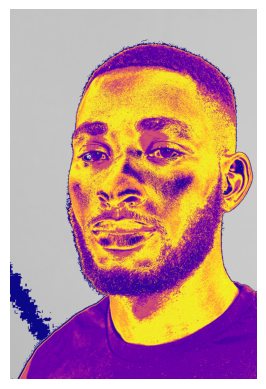

In [24]:
intensity_histograms = mask_handler.get_intensity_histograms(
    IMAGE_PATH,
    masks
)

Utils.visualize_histograms(intensity_histograms)
Utils.apply_intensity_probability_map(IMAGE_PATH, intensity_histograms[0])

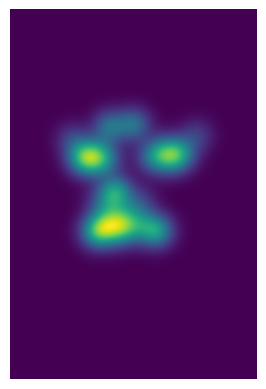

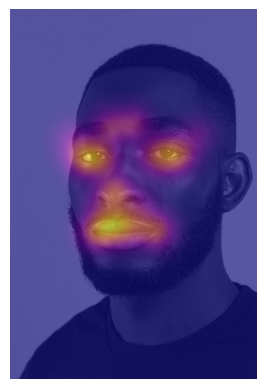

In [25]:
prior_face_masks, heatmaps, heatmaps_blended = mask_handler.get_prior_face_masks(
    IMAGE_PATH, selected_pts
)

idx = 0
Utils.display(prior_face_masks[idx])
Utils.display(heatmaps_blended[idx])

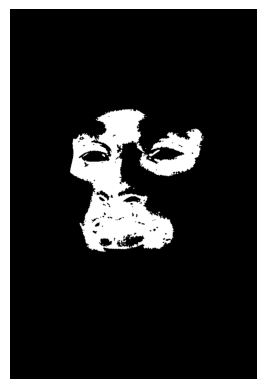

In [26]:
alpha = 0.9
lambda_ = 0.003

skin_pixel_maps = mask_handler.get_skin_pixel_maps(
    IMAGE_PATH,
    intensity_histograms,
    prior_face_masks,
    alpha,
    lambda_,
    selected_pts,
    force_reject=True
)

skin_pixel_maps = [Utils.morphological_cleanup(s) for s in skin_pixel_maps]

Utils.display(skin_pixel_maps[0], cmap="gray")

In [27]:
superpixel_extractor = SuperpixelExtractor()
slic_superpixels, contoured_img, slic_labels, num_superpixels = superpixel_extractor.get_slic_superpixels(IMAGE_PATH)

print(num_superpixels)

8214


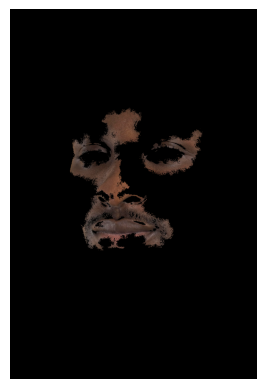

In [28]:
idx = 0
mask_superpixel_labels = superpixel_extractor.get_mask_labels(slic_superpixels, skin_pixel_maps[idx], 0.9)
Utils.display_selected_superpixels(IMAGE_PATH, slic_labels, mask_superpixel_labels)

In [29]:
feature_extractor = FeatureExtractor()
all_feature_vectors = feature_extractor.extract_all_features_superpixels(
    IMAGE_PATH,
    slic_superpixels
)

print(len(all_feature_vectors))

8214


In [30]:
mask_fv, non_mask_fv = FeatureExtractor.separate_feature_vectors(
    all_feature_vectors,
    mask_superpixel_labels
)

print(f"num_mask = {len(mask_fv)} | num_non_mask = {len(non_mask_fv)} | total = {len(mask_fv) + len(non_mask_fv)}")

num_mask = 564 | num_non_mask = 7650 | total = 8214


In [31]:
FEATURE_SELECTION = [
    EFeature.MEAN_INTENSITY,
    EFeature.STD_INTENSITY,
    EFeature.ENTROPY,
    EFeature.LACUNARITY_VECTOR
]

In [32]:
most_favorable_divergence = [
    nfv.get_most_favorable_divergence(mask_fv, FEATURE_SELECTION)
    for nfv in non_mask_fv
    
]

[1450, 1524, 1527, 1605, 1653, 1670, 1728, 1733, 1756, 1758, 1816, 1901, 2037, 2049, 2100, 2104, 2203, 2243, 2253, 2265, 2267, 2317, 2321, 2390, 2408, 2428, 2430, 2464, 2466, 2493, 2495, 2498, 2508, 2576, 2685, 2718, 2719, 2764, 2784, 2839, 2859, 2984, 3072, 3169, 3239, 3288, 3393, 3462, 3533, 3538, 3608, 3764, 3832, 3887, 3961, 4112, 4127, 4131, 4198, 4270, 4286, 4714, 4862, 5009, 5155, 5442, 5445, 5902, 5976, 6263, 6411, 6420, 6492, 6547, 6552, 6638, 6866]


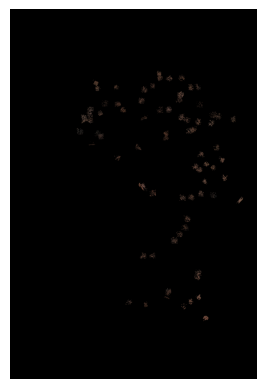

In [33]:
region = Region()

seed_superpixel_labels = region.select_seed_superpixels(
    most_favorable_divergence,
    FEATURE_SELECTION,
    0.99
)

print(seed_superpixel_labels)
Utils.display_selected_superpixels(IMAGE_PATH, slic_labels, seed_superpixel_labels)

Starting Iterations of Region Growing Algorithm
----- Iteration 1/3 -----
Added 1520 superpixels: [2048, 4096, 2050, 2053, 4107, 4108, 4110, 4111, 4113, 4114, 4115, 4121, 4122, 4123, 4124, 4125, 4126, 4128, 4129, 4130, 4132, 4138, 2095, 2099, 2101, 2102, 2103, 2105, 2106, 2108, 2110, 2111, 2112, 2117, 4168, 2121, 2122, 2123, 2124, 4173, 4174, 4169, 4177, 2129, 2130, 4183, 4184, 4185, 4186, 4187, 4194, 4196, 4197, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4213, 6264, 6265, 2169, 2170, 2171, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2190, 2192, 2193, 2194, 4243, 2195, 4245, 2201, 2202, 4254, 4255, 4256, 4259, 4268, 4269, 4271, 4272, 4273, 4274, 4275, 4284, 4285, 6335, 6336, 6337, 6338, 2242, 2244, 2245, 2246, 2247, 2248, 6345, 6346, 2251, 2252, 6347, 2249, 2256, 2257, 2258, 2259, 2263, 2264, 2266, 4315, 4316, 2268, 2269, 4319, 2270, 2273, 2275, 2276, 2277, 2278, 2280, 2281, 2282, 4332, 2284, 4343, 4345, 6399, 4352, 4359, 6410, 2315, 6412, 2316, 2318, 2

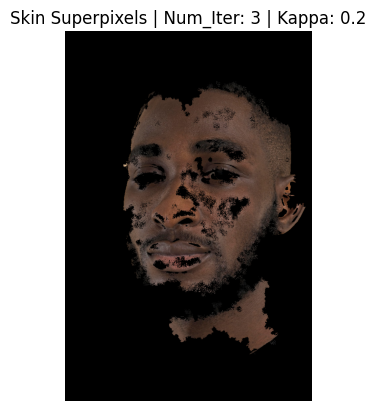

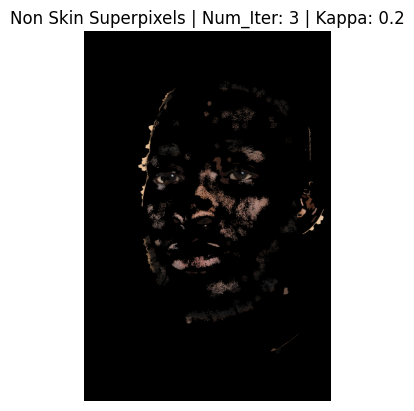

In [34]:
num_iterations = 3
kappa = 0.2

skin_superpixel_labels, non_skin_superpixel_labels = region.grow(
    slic_superpixels,
    seed_superpixel_labels,
    all_feature_vectors,
    most_favorable_divergence,
    mask_superpixel_labels,
    FEATURE_SELECTION,
    num_iterations,
    kappa,
)

Utils.display_selected_superpixels(
    IMAGE_PATH,
    slic_labels,
    skin_superpixel_labels,
    title=f"Skin Superpixels | Num_Iter: {num_iterations} | Kappa: {kappa}"
)

Utils.display_selected_superpixels(
    IMAGE_PATH,
    slic_labels,
    non_skin_superpixel_labels,
    title=f"Non Skin Superpixels | Num_Iter: {num_iterations} | Kappa: {kappa}"
)

In [35]:
# ============================================================================
# FINAL CELL: Feature Combination Analysis, Grid Display, and SAVING THE GRID IMAGE
# Saves the final matplotlib grid figure instead of individual images.
# ============================================================================
import itertools
import matplotlib.pyplot as plt
import math
import time
import numpy as np
import cv2  # Make sure cv2 is imported
from pathlib import Path
from typing import List, Tuple, Set, Dict  # Import necessary types if not already imported globally
import re  # For creating safe filenames


# --- Helper Function: Generate Superpixel Visualization Image (Masking Version) ---
# This local function is necessary because Utils.display_selected_superpixels displays
# but doesn't return the array needed for the grid plotting within this cell.
def generate_selected_superpixels_image_local_masked(
        img_path: Path,
        slic_labels: np.ndarray,
        selected_labels: List[int],
) -> np.ndarray:
    """
    Generates an image highlighting selected superpixels by masking.
    Returns the image array (BGR format).
    """
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        try:
            img_bgr = cv2.imread(str(IMAGE_PATH)); assert img_bgr is not None
        except:
            raise FileNotFoundError(f"Image not found at {img_path} or {IMAGE_PATH}")

    output_img = np.zeros_like(img_bgr)
    selected_label_set = set(selected_labels)
    selected_pixel_mask = np.zeros(slic_labels.shape, dtype=bool)
    max_label = np.max(slic_labels) if slic_labels.size > 0 else -1
    for label in selected_label_set:
        if 0 <= label <= max_label: selected_pixel_mask[slic_labels == label] = True
    output_img[selected_pixel_mask] = img_bgr[selected_pixel_mask]
    return output_img


# --- Define ALL available features ---
try:
    ALL_AVAILABLE_FEATURES = [
        EFeature.MEAN_INTENSITY, EFeature.STD_INTENSITY,
        EFeature.ENTROPY, EFeature.LACUNARITY_VECTOR]
    num_all_features = len(ALL_AVAILABLE_FEATURES)
    total_combinations = 2 ** num_all_features - 1
    print(f"Identified {num_all_features} features. Will test {total_combinations} non-empty combinations.")
except NameError:
    print("Error: EFeature enum not defined."); raise

# --- Ensure required variables ---
required_vars = [
    'IMAGE_PATH', 'slic_superpixels', 'slic_labels', 'all_feature_vectors', 'mask_fv',
    'non_mask_fv', 'mask_superpixel_labels', 'region', 'num_iterations', 'kappa',
    'FeatureExtractor', 'Region', 'SuperpixelExtractor']
missing_vars = [var for var in required_vars if var not in locals() and var not in globals()]
if missing_vars: raise NameError(f"Missing required variables: {', '.join(missing_vars)}.")

# --- Parameters ---
seed_percentile_threshold = 0.99

# --- <<<< MODIFICATION: Define Output Subdirectory Name and Create It >>>> ---
# Change this variable to name your output subdirectory
output_subdir_name = f"sydney"

output_dir = Path("output_images") / output_subdir_name  # Create full path
output_dir.mkdir(parents=True, exist_ok=True)  # Create base and sub dirs
print(f"Output directory for grid image: {output_dir.resolve()}")
# --- <<<< END MODIFICATION >>>> ---

# --- Initialize results_data ---
results_data = []

print(f"\nStarting processing for {total_combinations} feature combinations...")
start_time = time.time()

# --- Loop through feature combinations ---
count = 0
skipped_count = 0
# Removed individual image saving counters

for r in range(1, num_all_features + 1):
    for current_feature_tuple in itertools.combinations(ALL_AVAILABLE_FEATURES, r):
        count += 1
        current_feature_list = list(current_feature_tuple)
        feature_names_str = ", ".join(sorted([f.name for f in current_feature_list]))
        feature_names_short = feature_names_str.replace('_', ' ').replace('VECTOR', 'VEC').replace('INTENSITY', 'INT')
        # safe_feature_name is no longer needed for individual files

        print(f"\n--- Processing Combination {count}/{total_combinations} ({feature_names_short}) ---")

        skin_img = None
        non_skin_img = None
        try:
            # 1. Most Favorable Divergence
            if not mask_fv: print(f"  Skipping: mask_fv is empty."); skipped_count += 1; continue
            if not non_mask_fv: print(f"  Skipping: non_mask_fv is empty."); skipped_count += 1; continue
            current_most_favorable_divergence = [nfv.get_most_favorable_divergence(mask_fv, current_feature_list) for
                                                 nfv in non_mask_fv]
            if not current_most_favorable_divergence: print(
                f"  Skipping: No divergence vectors generated."); skipped_count += 1; continue

            # 2. Select Seeds
            current_seed_superpixel_labels = region.select_seed_superpixels(current_most_favorable_divergence,
                                                                            current_feature_list,
                                                                            seed_percentile_threshold)
            if not current_seed_superpixel_labels: print(
                f"  Skipping: No seed superpixels found."); skipped_count += 1; continue

            # 3. Region Grow
            import sys;
            from io import StringIO

            old_stdout = sys.stdout;
            sys.stdout = captured_output = StringIO()
            current_skin_labels, current_non_skin_labels = region.grow(
                slic_superpixels=slic_superpixels, seed_superpixel_labels=current_seed_superpixel_labels,
                all_feature_vectors=all_feature_vectors, most_favorable_divergence=current_most_favorable_divergence,
                mask_superpixel_labels=mask_superpixel_labels, feature_selection=current_feature_list,
                num_iterations=num_iterations, kappa=kappa, )
            sys.stdout = old_stdout;
            captured_output.close()

            # 4. Generate Visualization Images using LOCAL helper
            skin_img = generate_selected_superpixels_image_local_masked(IMAGE_PATH, slic_labels, current_skin_labels, )
            non_skin_img = generate_selected_superpixels_image_local_masked(IMAGE_PATH, slic_labels,
                                                                            current_non_skin_labels, )
            print(f"  Successfully generated images for grid.")

            # --- <<<< REMOVAL: Individual Image Saving Block Removed >>>> ---

        except Exception as e:
            if 'old_stdout' in locals() and sys.stdout != old_stdout: sys.stdout = old_stdout
            print(f"  ERROR processing {feature_names_short}: {e}")
            import traceback;

            traceback.print_exc()
            skipped_count += 1
            skin_img = None;
            non_skin_img = None

        # 5. Store results (still needed for plotting)
        results_data.append({'features': feature_names_short, 'skin_img': skin_img, 'non_skin_img': non_skin_img})

end_time = time.time()
print(
    f"\nFinished processing {count} combinations ({count - skipped_count} successful computations, {skipped_count} skipped) in {end_time - start_time:.2f} seconds.")
# Removed individual saving summary


# --- Display results in a grid AND SAVE THE GRID ---
num_results = len(results_data)
if num_results > 0:
    valid_results = [res for res in results_data if
                     res.get('skin_img') is not None and res.get('non_skin_img') is not None]
    num_valid_results = len(valid_results)
    print(f"\nGenerating and saving grid for {num_valid_results} successful combinations...")
    if num_valid_results == 0: print("  (No successful combinations with images to display/save)"); exit()

    total_images_to_display = num_valid_results * 2
    cols = 8 if num_valid_results > 11 else 6 if num_valid_results > 5 else 4
    cols = min(cols, total_images_to_display)
    rows = math.ceil(total_images_to_display / cols)

    # Create the figure object - IMPORTANT for saving
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 3.0))  # Keep fig reference
    if rows * cols == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()

    img_idx = 0
    for i, result in enumerate(valid_results):
        features_title = result['features']

        if img_idx < len(axes):  # Display Skin
            ax = axes[img_idx];
            ax.imshow(cv2.cvtColor(result['skin_img'], cv2.COLOR_BGR2RGB))
            ax.set_title(f"Skin\n{features_title}", fontsize=6);
            ax.axis('off');
            img_idx += 1
        else:
            break

        if img_idx < len(axes):  # Display Non-Skin
            ax = axes[img_idx];
            ax.imshow(cv2.cvtColor(result['non_skin_img'], cv2.COLOR_BGR2RGB))
            ax.set_title(f"Non-Skin\n{features_title}", fontsize=6);
            ax.axis('off');
            img_idx += 1
        else:
            break

    for i in range(img_idx, len(axes)): axes[i].axis('off')  # Hide unused axes

    plt.tight_layout(pad=0.3, h_pad=0.8, w_pad=0.3)
    fig.suptitle(f'Region Growing Results (Masked) - {num_valid_results} Combinations (k={kappa}, it={num_iterations})',
                 fontsize=10, y=1.00)  # Use fig.suptitle

    # --- <<<< MODIFICATION: Save the entire figure >>>> ---
    grid_filename = f"feature_combinations_grid_k{kappa}_iter{num_iterations}.png"
    grid_filepath = output_dir / grid_filename

    if not grid_filepath.exists():
        try:
            fig.savefig(grid_filepath, dpi=200, bbox_inches='tight')  # Save the figure object
            print(f"Successfully saved grid image to: {grid_filepath}")
        except Exception as e_save:
            print(f"ERROR saving grid image {grid_filepath}: {e_save}")
    else:
        print(f"Grid image already exists (skipped saving): {grid_filepath}")
    # --- <<<< END MODIFICATION >>>> ---

    plt.show()  # Display the figure in the notebook
else:
    print("\nNo results available in 'results_data' to display or save.")


Identified 4 features. Will test 15 non-empty combinations.
Output directory for grid image: /Users/rachitkumar/projects/skin_detection/test/output_images/sydney

Starting processing for 15 feature combinations...

--- Processing Combination 1/15 (MEAN INT) ---


KeyboardInterrupt: 

Attempting to display image pairs horizontally from cached 'results_data'...
Found cached 'results_data' with 15 result pairs. Displaying sequentially side-by-side...


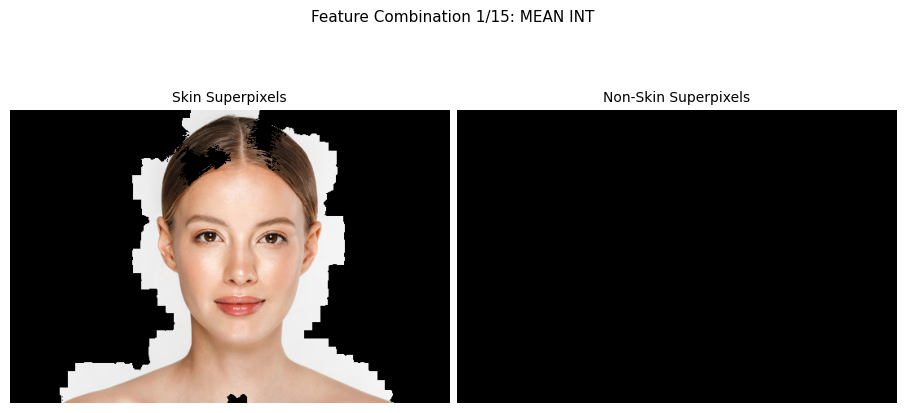

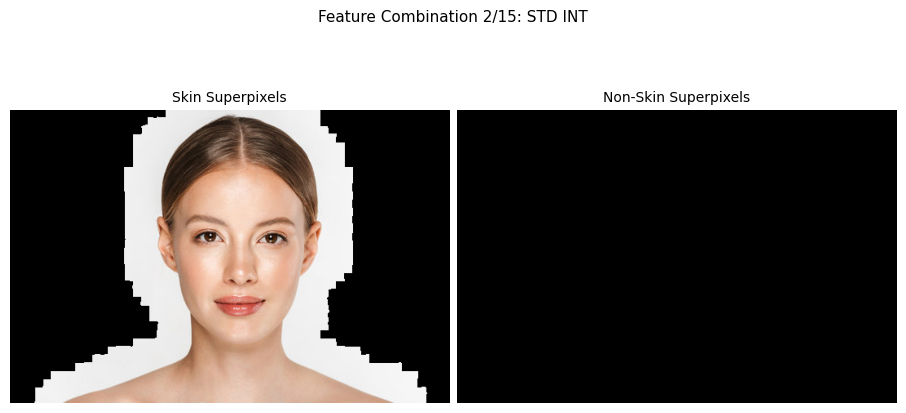

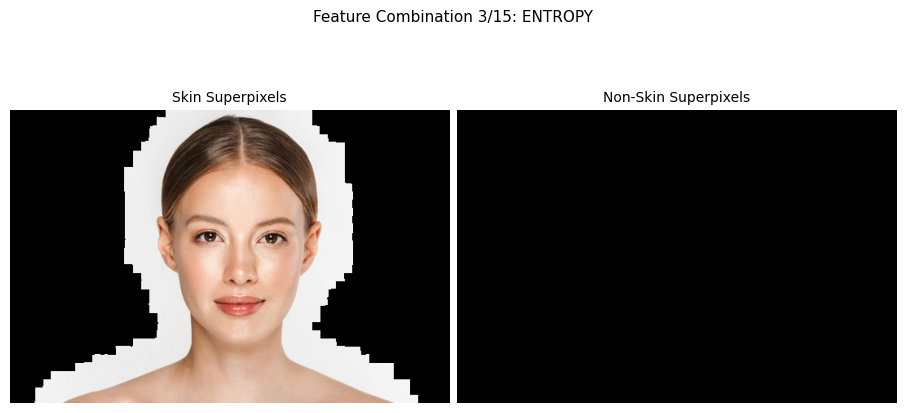

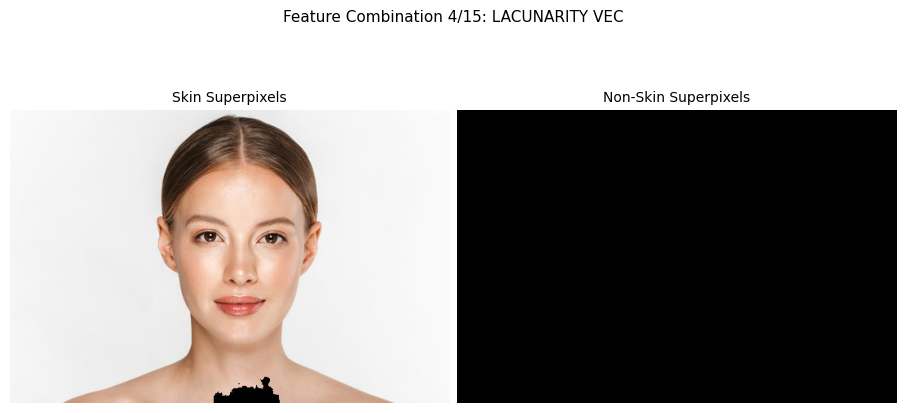

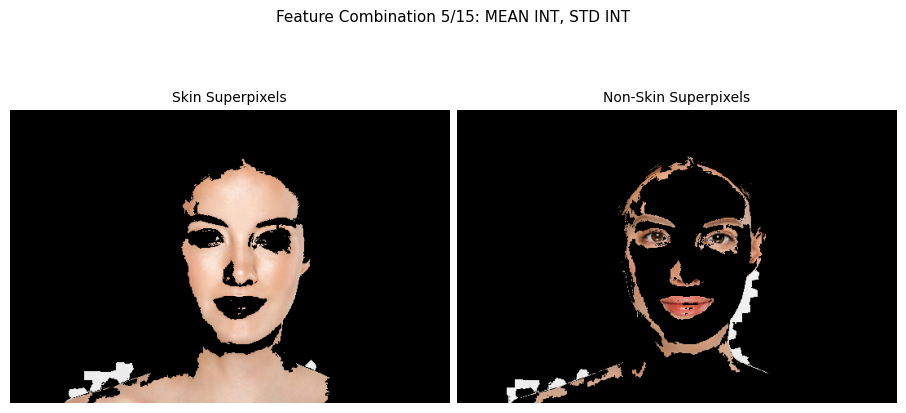

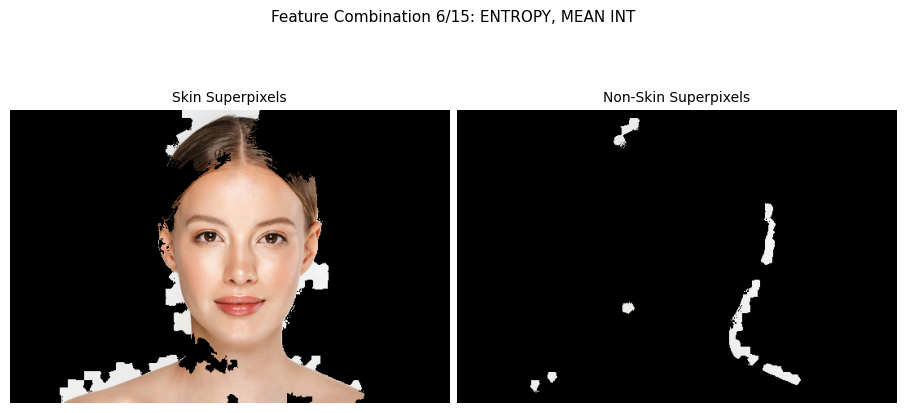

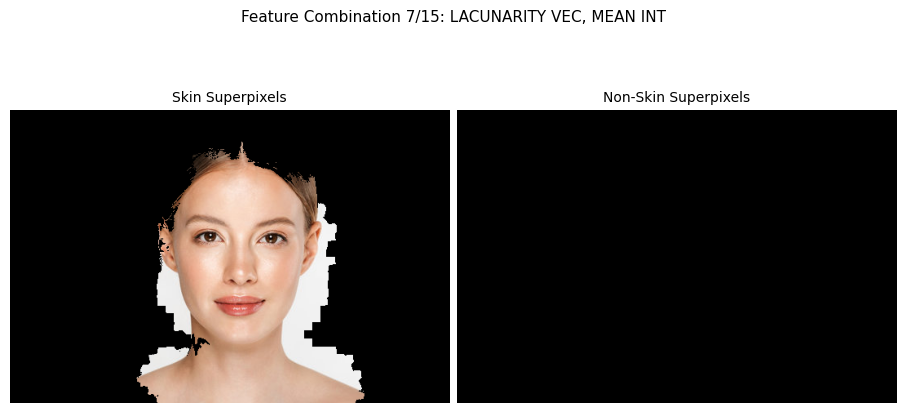

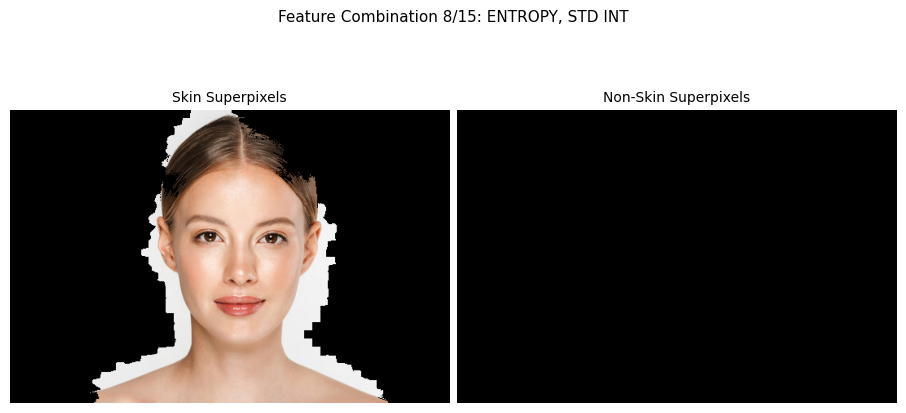

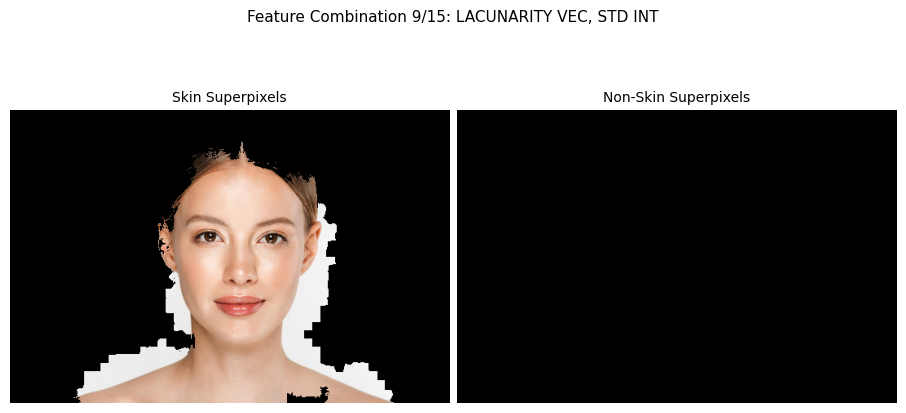

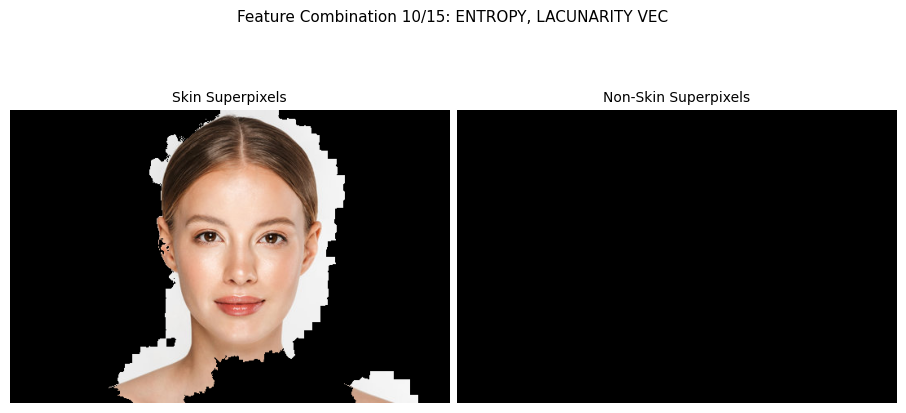

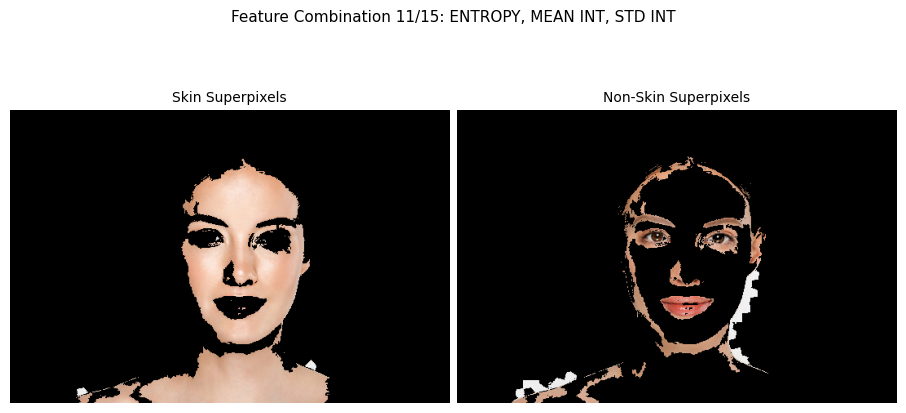

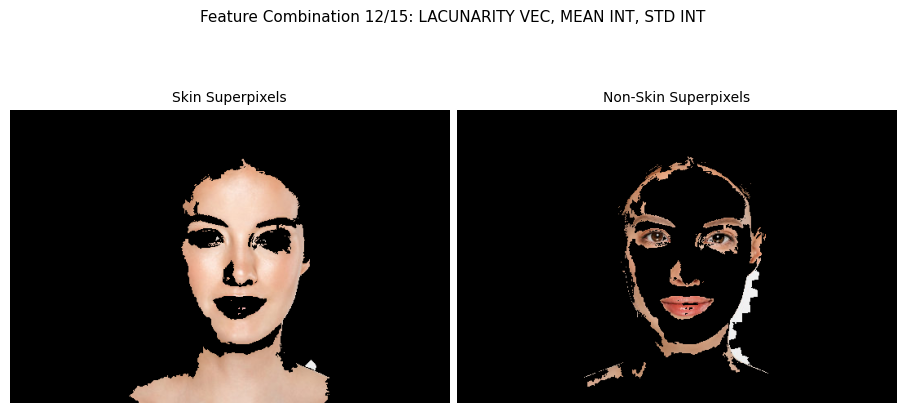

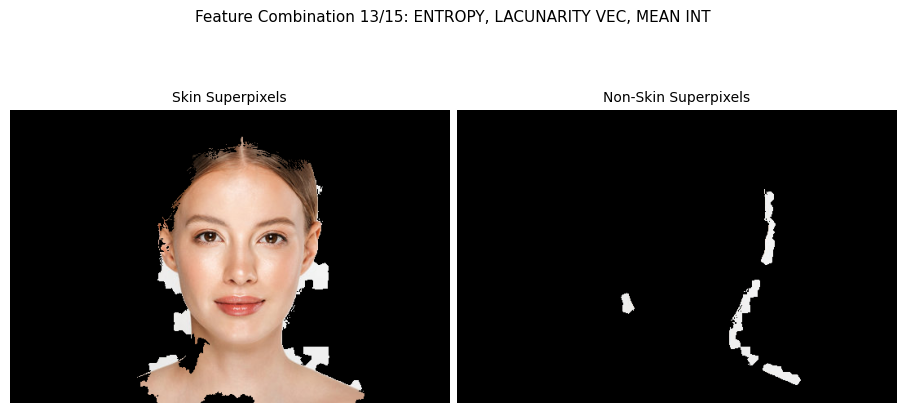

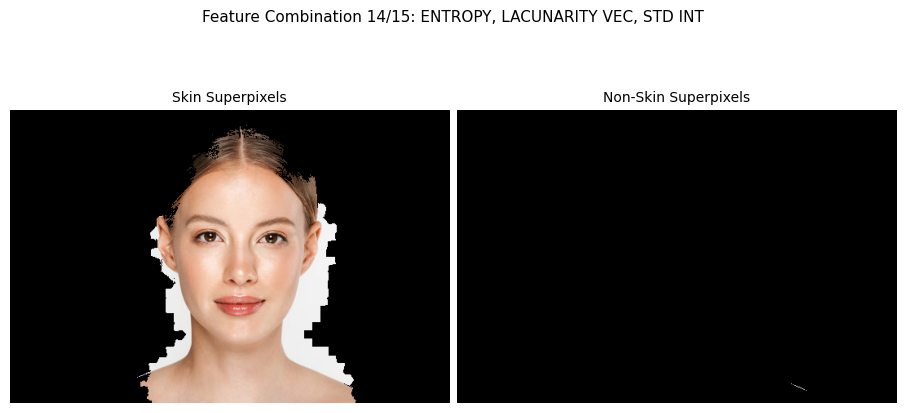

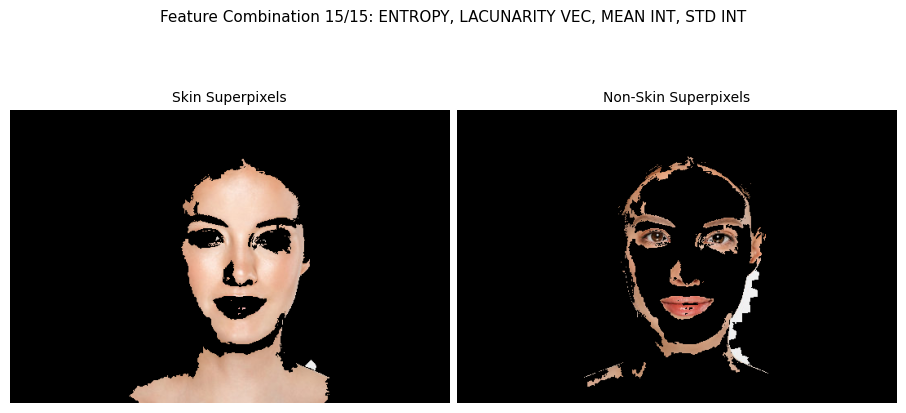


Finished displaying all 15 cached pairs horizontally.


In [40]:
# ============================================================================
# NEW CELL: Display Cached Image Pairs Sequentially (Horizontal Layout)
# ============================================================================
import matplotlib.pyplot as plt
import cv2  # Make sure cv2 is imported (needed for color conversion during display)
import numpy as np  # Might be needed if handling None results robustly

print("Attempting to display image pairs horizontally from cached 'results_data'...")

# --- Check if the cached data exists ---
if 'results_data' in locals() and isinstance(results_data, list) and results_data:
    num_pairs = len(results_data)
    print(f"Found cached 'results_data' with {num_pairs} result pairs. Displaying sequentially side-by-side...")

    # --- Loop through the cached results and display each pair ---
    for i, result in enumerate(results_data):
        # Retrieve data for the current pair from the cache
        features_title = result.get('features', f'Combination {i + 1}')
        skin_img = result.get('skin_img')
        non_skin_img = result.get('non_skin_img')

        # --- Create a Figure for this Pair ---
        # Adjust figsize to be wider for horizontal layout
        fig = plt.figure(figsize=(9, 4.5))  # Width, Height
        fig.suptitle(f"Feature Combination {i + 1}/{num_pairs}: {features_title}", fontsize=11, y=1.00)

        # --- Plot Skin Image (Left) ---
        ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, first plot
        if skin_img is not None and isinstance(skin_img, np.ndarray):
            # Convert BGR (from OpenCV generation) to RGB (for Matplotlib display)
            ax1.imshow(cv2.cvtColor(skin_img, cv2.COLOR_BGR2RGB))
            ax1.set_title(f"Skin Superpixels", fontsize=10)
        else:
            # Handle case where image generation might have failed and stored None
            ax1.text(0.5, 0.5, 'Skin Image\nNot Available', ha='center', va='center', fontsize=9, color='red')
            ax1.set_title(f"Skin Superpixels (Not Available)", fontsize=10)
        ax1.axis('off')  # Hide axes ticks and labels

        # --- Plot Non-Skin Image (Right) ---
        ax2 = fig.add_subplot(1, 2, 2)  # 1 row, 2 columns, second plot
        if non_skin_img is not None and isinstance(non_skin_img, np.ndarray):
            # Convert BGR to RGB
            ax2.imshow(cv2.cvtColor(non_skin_img, cv2.COLOR_BGR2RGB))
            ax2.set_title(f"Non-Skin Superpixels", fontsize=10)
        else:
            # Handle case where image generation might have failed
            ax2.text(0.5, 0.5, 'Non-Skin Image\nNot Available', ha='center', va='center', fontsize=9, color='red')
            ax2.set_title(f"Non-Skin Superpixels (Not Available)", fontsize=10)
        ax2.axis('off')  # Hide axes ticks and labels

        # --- Adjust Layout and Show Figure ---
        plt.tight_layout(pad=0.5, rect=[0, 0, 1, 0.95])  # Adjust layout, rect leaves space for suptitle
        plt.show()  # Display the current figure before the loop proceeds to the next pair

    print(f"\nFinished displaying all {num_pairs} cached pairs horizontally.")

else:
    # This message appears if the previous cell wasn't run or 'results_data' is empty/invalid
    print("\nError: Could not find valid cached 'results_data'.")
    print("Please ensure the previous cell that generates the feature combination results")
    print("has been run successfully in the current kernel session.")


Identified 4 features. Will test 15 non-empty combinations.
Output directory for grid image: /Users/rachitkumar/projects/skin_detection/test/output_images/sydney_skin_only

Starting processing for 15 feature combinations...

--- Processing Combination 1/15 (MEAN INT) ---
  Successfully generated skin image for grid.

--- Processing Combination 2/15 (STD INT) ---
  Successfully generated skin image for grid.

--- Processing Combination 3/15 (ENTROPY) ---
  Successfully generated skin image for grid.

--- Processing Combination 4/15 (LACUNARITY VEC) ---
  Successfully generated skin image for grid.

--- Processing Combination 5/15 (MEAN INT, STD INT) ---
  Successfully generated skin image for grid.

--- Processing Combination 6/15 (ENTROPY, MEAN INT) ---
  Successfully generated skin image for grid.

--- Processing Combination 7/15 (LACUNARITY VEC, MEAN INT) ---
  Successfully generated skin image for grid.

--- Processing Combination 8/15 (ENTROPY, STD INT) ---
  Successfully generated

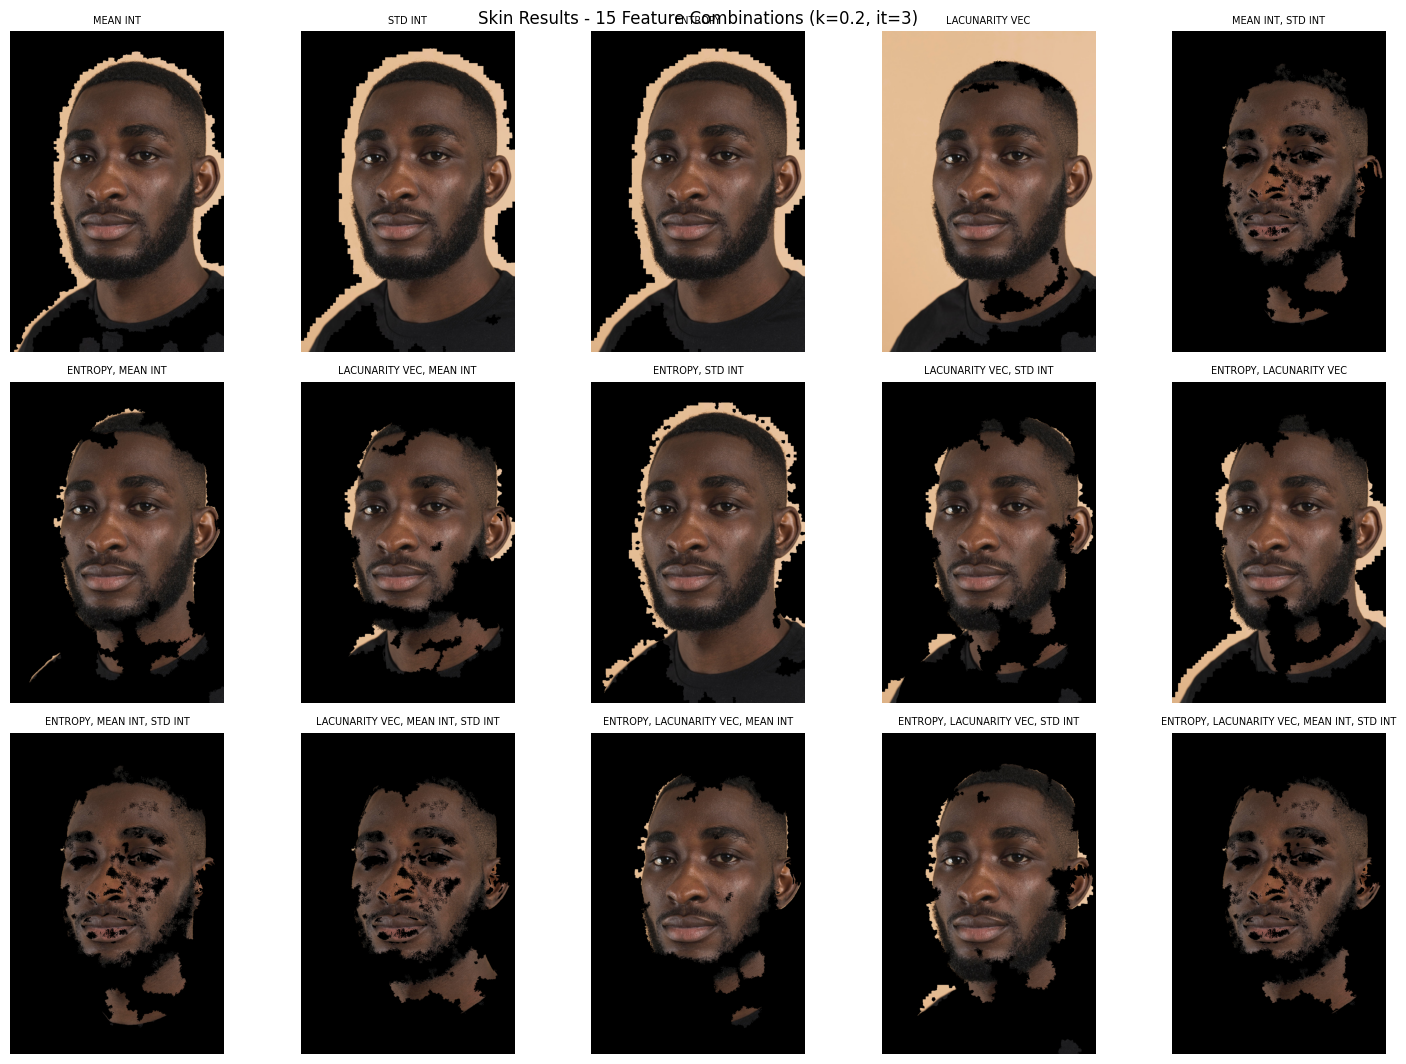

In [36]:
# ============================================================================
# FINAL CELL: Feature Combination Analysis, Grid Display (SKIN ONLY), and SAVING THE GRID IMAGE
# Saves the final matplotlib grid figure showing ONLY skin results.
# ============================================================================
import itertools
import matplotlib.pyplot as plt
import math
import time
import numpy as np
import cv2  # Make sure cv2 is imported
from pathlib import Path
from typing import List, Tuple, Set, Dict  # Import necessary types if not already imported globally
import re  # For creating safe filenames


# --- Helper Function: Generate Superpixel Visualization Image (Masking Version) ---
# This local function is necessary because Utils.display_selected_superpixels displays
# but doesn't return the array needed for the grid plotting within this cell.
def generate_selected_superpixels_image_local_masked(
        img_path: Path,
        slic_labels: np.ndarray,
        selected_labels: List[int],
) -> np.ndarray:
    """
    Generates an image highlighting selected superpixels by masking.
    Returns the image array (BGR format).
    """
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        try:
            img_bgr = cv2.imread(str(IMAGE_PATH));
            assert img_bgr is not None
        except:
            raise FileNotFoundError(f"Image not found at {img_path} or {IMAGE_PATH}")

    output_img = np.zeros_like(img_bgr)
    selected_label_set = set(selected_labels)
    selected_pixel_mask = np.zeros(slic_labels.shape, dtype=bool)
    max_label = np.max(slic_labels) if slic_labels.size > 0 else -1
    for label in selected_label_set:
        if 0 <= label <= max_label: selected_pixel_mask[slic_labels == label] = True
    output_img[selected_pixel_mask] = img_bgr[selected_pixel_mask]
    return output_img


# --- Define ALL available features ---
try:
    ALL_AVAILABLE_FEATURES = [
        EFeature.MEAN_INTENSITY, EFeature.STD_INTENSITY,
        EFeature.ENTROPY, EFeature.LACUNARITY_VECTOR]
    num_all_features = len(ALL_AVAILABLE_FEATURES)
    total_combinations = 2 ** num_all_features - 1
    print(f"Identified {num_all_features} features. Will test {total_combinations} non-empty combinations.")
except NameError:
    print("Error: EFeature enum not defined.");
    raise

# --- Ensure required variables ---
required_vars = [
    'IMAGE_PATH', 'slic_superpixels', 'slic_labels', 'all_feature_vectors', 'mask_fv',
    'non_mask_fv', 'mask_superpixel_labels', 'region', 'num_iterations', 'kappa',
    'FeatureExtractor', 'Region', 'SuperpixelExtractor']
missing_vars = [var for var in required_vars if var not in locals() and var not in globals()]
if missing_vars: raise NameError(f"Missing required variables: {', '.join(missing_vars)}.")

# --- Parameters ---
seed_percentile_threshold = 0.99

# --- Define Output Subdirectory Name and Create It ---
# Change this variable to name your output subdirectory
output_subdir_name = f"sydney_skin_only"  # Updated default name

output_dir = Path("output_images") / output_subdir_name  # Create full path
output_dir.mkdir(parents=True, exist_ok=True)  # Create base and sub dirs
print(f"Output directory for grid image: {output_dir.resolve()}")

# --- Initialize results_data ---
results_data = []

print(f"\nStarting processing for {total_combinations} feature combinations...")
start_time = time.time()

# --- Loop through feature combinations ---
count = 0
skipped_count = 0

for r in range(1, num_all_features + 1):
    for current_feature_tuple in itertools.combinations(ALL_AVAILABLE_FEATURES, r):
        count += 1
        current_feature_list = list(current_feature_tuple)
        feature_names_str = ", ".join(sorted([f.name for f in current_feature_list]))
        feature_names_short = feature_names_str.replace('_', ' ').replace('VECTOR', 'VEC').replace('INTENSITY', 'INT')

        print(f"\n--- Processing Combination {count}/{total_combinations} ({feature_names_short}) ---")

        skin_img = None
        non_skin_img = None  # Still calculate it, just won't plot it
        try:
            # 1. Most Favorable Divergence
            if not mask_fv: print(f"  Skipping: mask_fv is empty."); skipped_count += 1; continue
            if not non_mask_fv: print(f"  Skipping: non_mask_fv is empty."); skipped_count += 1; continue
            current_most_favorable_divergence = [nfv.get_most_favorable_divergence(mask_fv, current_feature_list) for
                                                 nfv in non_mask_fv]
            if not current_most_favorable_divergence: print(
                f"  Skipping: No divergence vectors generated."); skipped_count += 1; continue

            # 2. Select Seeds
            current_seed_superpixel_labels = region.select_seed_superpixels(current_most_favorable_divergence,
                                                                            current_feature_list,
                                                                            seed_percentile_threshold)
            if not current_seed_superpixel_labels: print(
                f"  Skipping: No seed superpixels found."); skipped_count += 1; continue

            # 3. Region Grow
            import sys;
            from io import StringIO

            old_stdout = sys.stdout;
            sys.stdout = captured_output = StringIO()
            current_skin_labels, current_non_skin_labels = region.grow(
                slic_superpixels=slic_superpixels, seed_superpixel_labels=current_seed_superpixel_labels,
                all_feature_vectors=all_feature_vectors, most_favorable_divergence=current_most_favorable_divergence,
                mask_superpixel_labels=mask_superpixel_labels, feature_selection=current_feature_list,
                num_iterations=num_iterations, kappa=kappa, )
            sys.stdout = old_stdout;
            captured_output.close()

            # 4. Generate Visualization Images using LOCAL helper
            skin_img = generate_selected_superpixels_image_local_masked(IMAGE_PATH, slic_labels, current_skin_labels, )
            # non_skin_img = generate_selected_superpixels_image_local_masked(IMAGE_PATH, slic_labels, current_non_skin_labels, ) # Generate if needed elsewhere, otherwise comment out
            print(f"  Successfully generated skin image for grid.")

        except Exception as e:
            if 'old_stdout' in locals() and sys.stdout != old_stdout: sys.stdout = old_stdout
            print(f"  ERROR processing {feature_names_short}: {e}")
            import traceback;

            traceback.print_exc()
            skipped_count += 1
            skin_img = None;
            non_skin_img = None  # Ensure reset on error

        # 5. Store results (only need skin_img for plotting now)
        results_data.append({'features': feature_names_short,
                             'skin_img': skin_img})  # Only store skin image if non_skin isn't needed later

end_time = time.time()
print(
    f"\nFinished processing {count} combinations ({count - skipped_count} successful computations, {skipped_count} skipped) in {end_time - start_time:.2f} seconds.")

# --- Display results in a grid (SKIN ONLY) AND SAVE THE GRID ---
num_results = len(results_data)
if num_results > 0:
    # Filter results where skin image generation was successful
    valid_results = [res for res in results_data if res.get('skin_img') is not None]
    num_valid_results = len(valid_results)
    print(f"\nGenerating and saving grid for {num_valid_results} successful skin combinations...")
    if num_valid_results == 0: print("  (No successful combinations with images to display/save)"); exit()

    # --- <<<< MODIFICATION: Grid calculation based on skin images only >>>> ---
    total_images_to_display = num_valid_results  # Only one image per result now
    # Adjust columns based on the number of skin images (e.g., max 5 wide for 15 images)
    cols = 5 if num_valid_results > 9 else 4 if num_valid_results > 5 else max(1, num_valid_results)
    cols = min(cols, total_images_to_display)
    rows = math.ceil(total_images_to_display / cols)
    # --- <<<< END MODIFICATION >>>> ---

    # Create the figure object - IMPORTANT for saving
    # --- <<<< MODIFICATION: Adjust figsize for potentially fewer rows >>>> ---
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.0, rows * 3.5))  # Adjust figsize
    # --- <<<< END MODIFICATION >>>> ---
    if rows * cols == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()

    img_idx = 0
    for i, result in enumerate(valid_results):
        features_title = result['features']

        # --- <<<< MODIFICATION: Only plot skin image >>>> ---
        if img_idx < len(axes):  # Display Skin
            ax = axes[img_idx];
            ax.imshow(cv2.cvtColor(result['skin_img'], cv2.COLOR_BGR2RGB))
            # Update title to only show features
            ax.set_title(f"{features_title}", fontsize=7);  # Slightly larger font now?
            ax.axis('off');
            img_idx += 1
        else:
            break
        # --- <<<< END MODIFICATION (Removed non-skin plotting block) >>>> ---

    for i in range(img_idx, len(axes)): axes[i].axis('off')  # Hide unused axes

    plt.tight_layout(pad=0.4, h_pad=1.0, w_pad=0.4)  # Adjust padding if needed
    # Update suptitle
    fig.suptitle(f'Skin Results - {num_valid_results} Feature Combinations (k={kappa}, it={num_iterations})',
                 fontsize=12, y=1.00)

    # --- Save the entire figure ---
    # Update grid filename slightly
    grid_filename = f"feature_combinations_grid_SKIN_ONLY_k{kappa}_iter{num_iterations}.png"
    grid_filepath = output_dir / grid_filename

    if not grid_filepath.exists():
        try:
            fig.savefig(grid_filepath, dpi=200, bbox_inches='tight')
            print(f"Successfully saved grid image to: {grid_filepath}")
        except Exception as e_save:
            print(f"ERROR saving grid image {grid_filepath}: {e_save}")
    else:
        print(f"Grid image already exists (skipped saving): {grid_filepath}")

    plt.show()  # Display the figure in the notebook
else:
    print("\nNo results available in 'results_data' to display or save.")